In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

path = "/home/yaning/Documents/"
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=float('inf'))

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
with open(path + "fire_data_10p_8f_non_zero.pkl", "rb") as f:
    fire_data = pickle.load(f)

In [18]:
fire_data = torch.tensor(fire_data, device=device)

In [37]:
fire_data.shape

torch.Size([100, 10, 10, 8, 6000])

In [207]:
# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

gMax_AMPA = 0.072
gMax_NMDA = 0.0012
gMax_GABA = 0.004

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 140

mg = 0.01

threshold = -50 + 70

# below parameters are all guesses
u_se = torch.tensor([0.9, 0.9, 0.9], device=device)

tau_rec = torch.tensor([12, 12, 12], device=device)
tau_pre = torch.tensor([10, 10, 10], device=device)
tau_post = torch.tensor([20, 10, 10], device=device)
tau_decay = torch.tensor([8, 15, 20], device=device)
tau_rise = torch.tensor([10, 7, 7], device=device)

learning_rate = 0.7

In [19]:
def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states


In [20]:
# # arrays of having AMPA, NMDA and GABA receptor (1 is have, 0 is not)
# # Q: should i use this or not, this slows it down but has more general use
# have_AMPA = recpetors_cells.clone()
# have_NMDA = recpetors_cells.clone()
# have_GABA = recpetors_cells.clone()

In [21]:
# have_AMPA.fill_(1)
# have_NMDA.fill_(1);

In [ ]:
def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# deri as deriviation 
def e_deri(e, on_off):
    return (1-e)/tau_rec[:,None,None] - u_se[:,None,None]*on_off

def g_decay_deri(g_decay, w, e, on_off):
    return -g_decay/tau_decay[:,None,None] + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    return -g_rise/tau_rise[:,None,None] + w*e*on_off

In [30]:
def update_gPs(e, g_decay, g_rise, activeness, w, deltaTms=0.05):
    # update e
    e = runge_kutta(e_deri, e, deltaTms, activeness)

    # update g_decay and g_rise
    # deltaTms * 10 is not good, when try to find the right params need to delete this
    g_decay = runge_kutta(g_decay_deri, g_decay, deltaTms*10, w, e, activeness)
    g_rise = runge_kutta(g_rise_deri, g_rise, deltaTms*10, w, e, activeness)

    gP = g_rise - g_decay

    return e, g_decay, g_rise, gP

run for now, haven't done: weight change/learning and prevent overfiring

In [ ]:
# the last param is how many synapses it needs to have 
def initialise(*args):
    cells = torch.zeros((args[0], args[1]), device=device)
    receptors = torch.zeros(args[2], 3, args[0], args[1], device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    initial_states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # receptor dimensions are (amount of synapses, type of receptors, cells)
    e = receptors.clone()
    e.fill_(1)

    # weight randomised at initial (0-1)
    # weight is special because it is not receptor-related but synapse
    w = torch.rand_like(cells)

    g_decay = receptors.clone()
    g_decay.fill_(1)

    g_rise = receptors.clone()
    g_rise.fill_(1)

    activeness = receptors.clone()
    activeness.fill_(0.)

    return cells, receptors, initial_states, mp, e, w, g_decay, g_rise, activeness

In [217]:
# initialise everything

#----------Input---------------
pixel_num = 10
feature_num = 8

#----------E---------------------
E_num = 20
E_cells, E_receptors, E_states, E_mp, E_e, E_w, E_g_decay, E_g_rise, E_activeness = initialise(E_num, E_num, 3)

#----------I-----------------
I_num = 4
I_cells, I_receptors, I_states, I_mp, I_e, I_w, I_g_decay, I_g_rise, I_activeness = initialise(I_num, I_num, 2)

#-----------Output-------------
Out_num = 5
Out_cells, Out_receptors, Out_states, Out_mp, Out_e, Out_w, Out_g_decay, Out_g_rise, Out_activeness = initialise(Out_num, Out_num, 1)

#-----------connection matrices-------------
In_con_E = torch.zeros(pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E.fill_(1.)

# the later two E_nums are the one sending out the connections/the center
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 10
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)


# E to I connection matrix (p=0.1)
E_con_I = torch.zeros(E_num, E_num, I_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1

# I to E connection matrix (p=0.024)
I_con_E = torch.zeros(I_num, I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1

# I to I self connection (p=0.1)
I_con_I = torch.zeros(I_num, I_num, I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1

# E to Out connection
E_con_Out = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 10
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Out[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)

In [165]:
one_pic = fire_data[25, :, :, :].float()

In [209]:
def activeness_bond(activesness):
    return (1 - torch.exp(-activesness))

def check_fire(mp):
    activeness = (mp > threshold).float()
    return activeness

In [223]:
I_activeness.shape

torch.Size([2, 4, 4])

In [ ]:
update_gPs(E_e, E_g_decay, E_g_rise, E_activeness, E_w)

In [233]:
E_activeness.shape

torch.Size([3, 20, 20])

In [232]:
voltages = []
for t in tqdm(range(pointCount)):
    # check mp and which fires then change connected layer activeness
    # Input to E
    In_fire = one_pic[:, :, :, t]
    E_activeness_In = torch.einsum('ijkxy,ijk->xy', In_con_E, In_fire)
    E_activeness_In = activeness_bond(E_activeness_In)

    E_fire = check_fire(E_mp)
    # E to I
    I_activeness_E = torch.einsum('ijxy,ij->xy', E_con_I, E_fire)
    I_activeness_E = activeness_bond(I_activeness_E)

    # E to E (this einsum is getting ij instead of xy)
    E_activeness_E = torch.einsum('ijxy,xy->ij', E_con_E, E_fire)
    E_activeness_E = activeness_bond(E_activeness_E)

    # E to Out
    Out_activeness = torch.einsum('ijxy,ij->xy', E_con_Out, E_fire)
    Out_activeness = activeness_bond(Out_activeness)

    I_fire = check_fire(I_mp)
    # I to E
    E_activeness_I = torch.einsum('ijxy,ij->xy', I_con_E, I_fire)
    E_activeness_I = activeness_bond(E_activeness_I)

    # I to I
    I_activeness_I = torch.einsum('ijxy,ij->xy', I_con_I, I_fire)
    I_activeness_I = activeness_bond(I_activeness_I)

    E_activeness = torch.stack([E_activeness_In, E_activeness_E, E_activeness_I])
    E_activeness.unsqueeze(1).repeat(1,3,1,1)
    I_activeness = torch.stack([I_activeness_I, I_activeness_E])
    Out_activeness = Out_activeness.unsqueeze(0)

    E_states = update_states(E_mp, E_states)
    E_e, E_g_decay, E_g_rise, E_gP = update_gPs(E_e, E_g_decay, E_g_rise, E_activeness, E_w)

    I_states = update_states(I_mp, I_states)
    I_e, I_g_decay, I_g_rise, I_gP = update_gPs(I_e, I_g_decay, I_g_rise, I_activeness, I_w)

    Out_states = update_states(Out_mp, Out_states)
    Out_e, Out_g_decay, Out_g_rise, Out_gP = update_gPs(Out_e, Out_g_decay, Out_g_rise, Out_activeness, Out_w)


    # generate currents based on gPs
    E_AMPA_currents = gMax_AMPA*E_gP[0]*(E_mp-rE_AMPA)*E_activeness
    E_NMDA_currents = gMax_NMDA*E_gP[1]*(1/1+mg*torch.exp(-0.062*E_mp)/3.57)*(E_mp-rE_NMDA)*E_activeness
    E_GABA_currents = gMax_GABA*E_gP[2]*(E_mp-rE_GABA)*(-1)*E_activeness
    
    E_sodium_currents = gMax_Na*torch.pow(E_states[0], 3) * E_states[2]*(E_mp-rE_Na)
    E_potassium_currents = gMax_K*torch.pow(E_states[1], 4)*(E_mp-rE_K)
    E_leaky_currents = gMax_leaky*(E_mp-rE_leaky)

    total_c = - E_sodium_currents - E_potassium_currents - E_leaky_currents - (
        E_AMPA_currents + E_NMDA_currents + E_GABA_currents
    )
    E_mp = E_mp + deltaTms*total_c/Cm

    I_AMPA_currents = gMax_AMPA*I_gP[0]*(I_mp-rE_AMPA)*I_activeness[0]
    I_NMDA_currents = gMax_NMDA*I_gP[1]*(1/1+mg*torch.exp(-0.062*I_mp)/3.57)*(I_mp-rE_NMDA)*I_activeness[1]
    I_GABA_currents = gMax_GABA*I_gP[2]*(I_mp-rE_GABA)*(-1)*I_activeness[2]
    
    I_sodium_currents = gMax_Na*torch.pow(I_states[0], 3) * I_states[2]*(I_mp-rE_Na)
    I_potassium_currents = gMax_K*torch.pow(I_states[1], 4)*(I_mp-rE_K)
    I_leaky_currents = gMax_leaky*(I_mp-rE_leaky)
    
    total_c = - I_sodium_currents - I_potassium_currents - I_leaky_currents - (
        I_AMPA_currents + I_NMDA_currents + I_GABA_currents
    )
    I_mp = I_mp + deltaTms*total_c/Cm

    Out_AMPA_currents = gMax_AMPA*Out_gP[0]*(Out_mp-rE_AMPA)*Out_activeness[0]
    Out_NMDA_currents = gMax_NMDA*Out_gP[1]*(1/1+mg*torch.exp(-0.062*Out_mp)/3.57)*(Out_mp-rE_NMDA)*Out_activeness[1]
    Out_GABA_currents = gMax_GABA*Out_gP[2]*(Out_mp-rE_GABA)*(-1)*Out_activeness[2]
    
    Out_sodium_currents = gMax_Na*torch.pow(Out_states[0], 3) * Out_states[2]*(Out_mp-rE_Na)
    Out_potassium_currents = gMax_K*torch.pow(Out_states[1], 4)*(Out_mp-rE_K)
    Out_leaky_currents = gMax_leaky*(Out_mp-rE_leaky)

    total_c = - Out_sodium_currents - Out_potassium_currents - Out_leaky_currents - (
        Out_AMPA_currents + Out_NMDA_currents + Out_GABA_currents
    )
    Out_mp = Out_mp + deltaTms*total_c/Cm
    
    

    voltages.append(E_AMPA_currents[10,10].cpu()-70)

  0%|                                                                                                                                           | 0/6000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

In [196]:
voltages

[tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-70.),
 tensor(-7

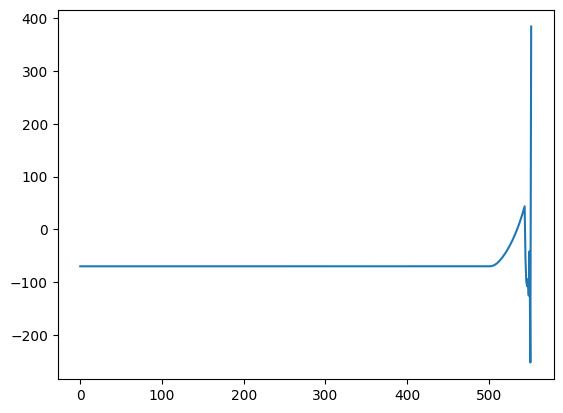

In [200]:
plt.plot(np.arange(pointCount), voltages)